In [18]:
import pandas as pd
import torch
import nltk
import re
from typing import List
from sklearn.metrics import f1_score, confusion_matrix
import seaborn
import json

from split_data import CATEGORIES

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

df = pd.read_csv('./data/train.tsv', sep='\t')

def tokenize_text(text: str) -> List[str]:
    text = re.sub(r'([a-z])- ([a-z])', '\1\2', text) # Saw hyphens like this in the middle of a lot of words e.g. "transmission elec- tron microscopy". Seem like line breaks
    return nltk.tokenize.word_tokenize(text)

pd.DataFrame([(tokenize_text(t),l) for t,l in df.to_records(index=False)], columns=df.columns)

In [ ]:
class TextDataset(torch.Dataset):
    def __init__(self, train=True):
        path = f'./data/{"train" if train else "test"}.tsv'
        self.data = pd.read_csv(path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = tokenize_text(self.data.iloc[idx, 0])
        label = self.data.iloc[idx, 1]
        return text, label

In [3]:
train = pd.read_csv('../data/train.tsv', sep='\t')
test = pd.read_csv('../data/test.tsv', sep='\t')
df = pd.concat((train, test))
records = df.to_records(index=False)

In [28]:
cons = {"Co." , "Ltd." ,"USA" ,"China" ,"India" ,"purchase" ,"procure","France","Belgium"}
prop = {"weight" ,"volume" , "thickness" ,"melt flow index" , "density" ,  "aspect ratio" , "glass transition ratio" , "diameter" , "viscocity" , "elongation" , "yield stress" , "conductivity" , "boiling point" , "size","properties","dielectric"}
act = {"add" , "stir" ,"dry" , "dried" , "anneal" , "disperse" , "wash","prepare","mix" ,"heated","rinsed"}

preds = []
for text, label in records:
    # const, prop, act
    counts = {k: 0 for k in CATEGORIES} # ['action', 'constituent', 'unrelated', 'property']
    split_txt = text.split(' ')
    for word in split_txt:
        if word in cons:
            counts['constituent'] += 1
        if word in prop:
            counts['property'] += 1
        if word in act:
            counts['action'] += 1
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    top_val = counts[0]
    preds.append(top_val[0] if top_val[1] > 0 else 'unrelated')
preds   

['unrelated',
 'unrelated',
 'property',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'property',
 'property',
 'action',
 'property',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'action',
 'unrelated',
 'unrelated',
 'unrelated',
 'property',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'action',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'property',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'property',
 'unrelated',
 'unrelated',
 'unrelated',
 'action',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'action',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',
 'unrelated',


In [27]:
a = {'a': 1, 'b': 2, 'c': 3}
sorted(a.items(), key=lambda x: x[1], reverse=True)

[('c', 3), ('b', 2), ('a', 1)]

In [29]:
df['rule_preds'] = preds

In [39]:
list(zip(CATEGORIES, f1_score(df.label, df.rule_preds, average=None, labels=CATEGORIES)))

[('action', 0.2183622828784119),
 ('constituent', 0.12844036697247707),
 ('unrelated', 0.2205029013539652),
 ('property', 0.4607843137254902)]

action,0.2183622828784119
constituent,0.12844036697247707
unrelated,0.2205029013539652
property,0.4607843137254902

Text(0.5, 23.52222222222222, 'True')

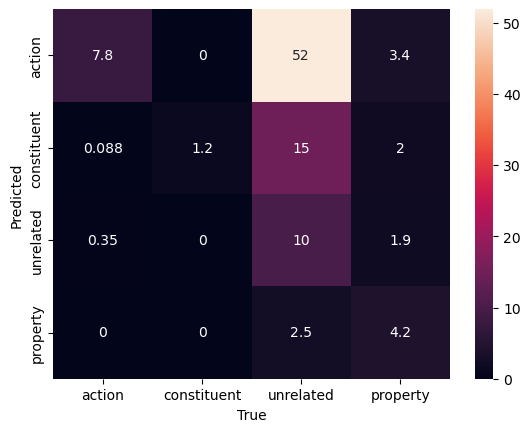

In [45]:
conf = confusion_matrix(df.label, df.rule_preds, labels=CATEGORIES, normalize='all') * 100
ax = seaborn.heatmap(conf, annot=True, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
ax.set_ylabel('Predicted')
ax.set_xlabel('True')